# ORLA: learning to play Takeaway
[_Keepaway_](https://www.cs.utexas.edu/~AustinVilla/sim/keepaway/) is a soccer-like game in which a team of _keepers_ and a team of _takers_ compete for the possession of the ball. The game always starts with one of the keepers having possession of the ball. [_Takeaway_](https://arxiv.org/abs/2004.07928) is the name that Keepaway receives when the takers are the only learning agents and the keepers follow a fixed policy. Our Takeaway matches are played with 4 keepers and 3 Takers on a 40x40 field (unless stated otherwise). Here is a screenshot showing what a newly generated Takeaway match looks like:
<center><img src="../imgs/keepaway_screenshot.png" width="300"></center>

To solve the takeaway task, an expert proposes the following arguments (in brackets, the corresponding naming in our paper): TakleBallX ($TB_i$), MinAngleX,Y ($A_ij$), MinDistX,Y ($C_i,j$), OpenKeeperX,Y ($O_ij$), and FarKeeperX,Y ($F_ij$). See paper for further details.

This notebook explains how ORLA can be used to decode both a local ($\texttt{M}_\text{loc}$) and global ($\texttt{M}_\text{glob}$) ranking.

## Setting things up
### Imports

In [1]:
from argumentation import utils as argm
from environments.takeaway import utils as tkwy
from environments.takeaway.takeaway import Takeaway
from agents.orla import ORLABaseline
import utils

import numpy as np
import torch
from tqdm.notebook import tqdm
from utils import plot_returns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### Connecting with RoboCup

Takeaway is implemented on [rcssserver](https://github.com/omcandido/rcssserver_orla) and uses the [keepaway library](https://github.com/omcandido/keepaway_orla) as an interface with the learning agents. Here, ORLA assumes that takewaway runs on a WSL2 instance and connects to it via sockets:

In [2]:
send_host = tkwy.get_host('send')
send_port = 7000
recv_host = tkwy.get_host('recv')
recv_port = 7001

### Loading the expert arguments

In [7]:
argument_actions = tkwy.arg_actions
arguments = list(argument_actions.keys())

print("There are {} expert arguments: {}".format(len(arguments), arguments))

There are 39 expert arguments: ['TackleBall1', 'OpenKeeper1,2', 'FarKeeper1,2', 'MinAngle1,2', 'MinDist1,2', 'OpenKeeper1,3', 'FarKeeper1,3', 'MinAngle1,3', 'MinDist1,3', 'OpenKeeper1,4', 'FarKeeper1,4', 'MinAngle1,4', 'MinDist1,4', 'TackleBall2', 'OpenKeeper2,2', 'FarKeeper2,2', 'MinAngle2,2', 'MinDist2,2', 'OpenKeeper2,3', 'FarKeeper2,3', 'MinAngle2,3', 'MinDist2,3', 'OpenKeeper2,4', 'FarKeeper2,4', 'MinAngle2,4', 'MinDist2,4', 'TackleBall3', 'OpenKeeper3,2', 'FarKeeper3,2', 'MinAngle3,2', 'MinDist3,2', 'OpenKeeper3,3', 'FarKeeper3,3', 'MinAngle3,3', 'MinDist3,3', 'OpenKeeper3,4', 'FarKeeper3,4', 'MinAngle3,4', 'MinDist3,4']


### The environment
The environment evaluates the ranking decoded by ORLA by using it as a reasoning engine by the takers on a Takeaway match.
The variable _ranking_path_ contains the file with the ranking decoded by ORLA, which is updated before every match and directly read by the takers

In [8]:
ranking_path = r"\\wsl.localhost\Ubuntu16\home\candido\keepaway_orla\player\orla\ordering.txt"
env = Takeaway(
    argument_actions,
    send_host,
    send_port,
    recv_host,
    recv_port,
    ranking_path
)

## Experiment 1

### The agent: $\mathtt{M}_\text{loc}$
We call $\mathtt{M}_\text{loc}$ to the ORLA model resulting from learning a strict ranking over the expert arguments. Note that our learning model consists of two sets of parameters: $\alpha^\theta$ (the preference function, in this case, the NN) and $\alpha^w$ (the baseline). This is the agent of the RL pipeline: 

In [9]:
alpha_th = 5e-5
alpha_w = utils.estimate_alpha_w(len(arguments), 1e5)

mode = utils.Mode.STRICT
orla_loc = ORLABaseline(arguments,alpha_th, alpha_w, device, mode)

In [10]:
orla_loc.decode_ranking()

([['OpenKeeper2,2'],
  ['MinDist2,2'],
  ['FarKeeper3,3'],
  ['OpenKeeper3,2'],
  ['OpenKeeper2,3'],
  ['OpenKeeper1,2'],
  ['MinAngle2,2'],
  ['MinAngle3,4'],
  ['OpenKeeper2,4'],
  ['TackleBall3'],
  ['FarKeeper1,3'],
  ['OpenKeeper1,3'],
  ['TackleBall1'],
  ['OpenKeeper3,4'],
  ['MinAngle1,3'],
  ['FarKeeper3,4'],
  ['MinDist1,2'],
  ['MinDist1,4'],
  ['FarKeeper3,2'],
  ['OpenKeeper1,4'],
  ['MinDist1,3'],
  ['MinAngle3,3'],
  ['MinDist3,2'],
  ['MinDist3,3'],
  ['MinDist2,3'],
  ['MinAngle3,2'],
  ['FarKeeper2,4'],
  ['MinDist3,4'],
  ['MinDist2,4'],
  ['TackleBall2'],
  ['MinAngle1,2'],
  ['OpenKeeper3,3'],
  ['FarKeeper1,2'],
  ['MinAngle1,4'],
  ['MinAngle2,3'],
  ['FarKeeper2,3'],
  ['FarKeeper1,4'],
  ['FarKeeper2,2'],
  ['MinAngle2,4']],
 tensor([0.0282, 0.0368, 0.0241, 0.0325, 0.0309, 0.0269, 0.0247, 0.0341, 0.0364,
         0.0336, 0.0306, 0.0460, 0.0484, 0.0350, 0.0428, 0.0454, 0.0320, 0.0500,
         0.0314, 0.0484, 0.0513, 0.0680, 0.0609, 0.0622, 0.0658, 0.0635, 0.096

#### Load the model
Optionally, we can load a (pre)trained model.

In [6]:
# orla_loc.w = np.load("saved_models/orla_local/w.npy")
# orla_loc.net.load_state_dict(torch.load("saved_models/orla_local/model.pt"))

### Training
We train in mini-batches.

Note: it is a good idea to visualize in the beginning how the probabilities of picking first arguments 0, 13 and 26 (TackleBall arguments) evolve to check that the learning rate is not too high. I chose these arguments because they are expected to be the most important ones, according to the expert, so seeing their probabilities slowly increase is a good sign.

In [7]:
batch_size = 8

returns = []
rankings_batch = []
probs_batch = []
returns_batch = []

t_episodes = tqdm(range(1, int(4e3)+1))
for episode in t_episodes:
    orla_loc.net.train()
    ranking, prob = orla_loc.decode_ranking()
    score = env.play(ranking)
    returns.append(score)

    rankings_batch.append(ranking)
    probs_batch.append(prob)
    returns_batch.append(score)
    
    if len(rankings_batch) == batch_size:
        orla_loc.learn(rankings_batch, probs_batch, returns_batch)
        rankings_batch = []
        probs_batch = []
        returns_batch = []
        past = 1000
        t_episodes.set_postfix({'avg': np.average(returns[-past:]), 'last': np.sum(returns[-batch_size:])/batch_size})

    # # Print the probabilities of Tackleball_{1,2 and 3} being the first chosen argument.
    # # It can give you an idea of how good your learning rate is:
    # orla_loc.net.eval()
    # ranking = []
    # state = argm.ranking_to_matrix(ranking, args, True)
    # state = torch.from_numpy(state).float().flatten().to(device)
    # remaining = orla_loc.remaining_arguments(ranking)
    # mask = orla_loc.mask_remaining(remaining)
    # orla_loc.net.mask = torch.from_numpy(mask).bool().to(device)
    # print(orla_loc.net(state)[0].item(), orla_loc.net(state)[13].item(), orla_loc.net(state)[26].item())


  0%|          | 0/4000 [00:00<?, ?it/s]

#### Learning curve
We plot the learning curve of the model by applying a rolling window (feel free to train it further to ensure convergence).

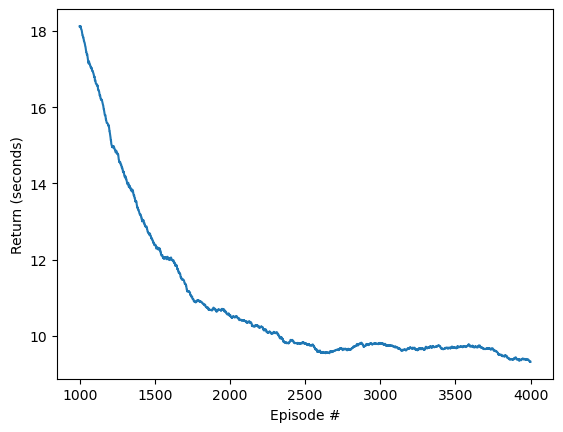

In [8]:
plot_returns(returns, window = 1000)

### Save the model
If you are done training the model, you can save it:

In [10]:
np.save("saved_models/orla_local/w.npy", orla_loc.w)
torch.save(orla_loc.net.state_dict(), "saved_models/orla_local/model.pt")

### Analysis of the local strategy
Let's see what strategy each of the $\mathtt{M}_\text{loc}$ takers has learned (note that this is model has been trained for demonstration purposes and its policy may differ from that shown in the paper):

In [11]:
ranking, probs = orla_loc.decode_ranking(True)
tkwy.show_ranking_by_taker(ranking)

    T1:  [['TackleBall1'], ['MinAngle1,2'], ['MinAngle1,3'], ['OpenKeeper1,4'], ['OpenKeeper1,2'], ['OpenKeeper1,3'], ['MinDist1,3'], ['MinDist1,4'], ['FarKeeper1,4'], ['MinAngle1,4'], ['FarKeeper1,3'], ['FarKeeper1,2'], ['MinDist1,2']]
    T2:  [['TackleBall2'], ['MinAngle2,3'], ['MinDist2,4'], ['MinAngle2,4'], ['OpenKeeper2,2'], ['OpenKeeper2,3'], ['MinAngle2,2'], ['OpenKeeper2,4'], ['FarKeeper2,3'], ['MinDist2,2'], ['FarKeeper2,4'], ['FarKeeper2,2'], ['MinDist2,3']]
    T3:  [['TackleBall3'], ['FarKeeper3,4'], ['MinDist3,2'], ['MinAngle3,3'], ['FarKeeper3,3'], ['MinAngle3,4'], ['MinAngle3,2'], ['OpenKeeper3,3'], ['OpenKeeper3,2'], ['OpenKeeper3,4'], ['MinDist3,3'], ['MinDist3,4'], ['FarKeeper3,2']]


## Experiment 2
### The agent: $\mathtt{M}_\text{glob}$
We call $\mathtt{M}_\text{glob}$ to the ORLA model resulting from learning a non-strict ranking over the expert arguments, by grouping the average rank of the arguments of the same type.

In [12]:
alpha_th = 4e-5
alpha_w = utils.estimate_alpha_w(len(args), 1e5)

MODE = utils.Mode.STRICT
orla_glob = ORLABaseline(args,alpha_th, alpha_w, device, mode)


### Optionally, load a pre(trained) model

In [13]:
# orla_glob.w = np.load("saved_models/orla_global/w.npy")
# orla_glob.net.load_state_dict(torch.load("saved_models/orla_global/model.pt"))

### Training

In [14]:
batch_size = 8

returns = []
rankings_batch = []
probs_batch = []
returns_batch = []

t_episodes = tqdm(range(1, int(4e3)+1))
for episode in t_episodes:
    orla_glob.net.train()
    ranking, prob = orla_glob.decode_ranking()
    # Now obtain the global ranking:
    _, arg_val = tkwy.get_global_values(ranking)
    ranking = argm.values_to_ranking(arg_val)
    score = env.play(ranking)
    returns.append(score)

    rankings_batch.append(ranking)
    probs_batch.append(prob)
    returns_batch.append(score)
    
    if len(rankings_batch) == batch_size:
        orla_glob.learn(rankings_batch, probs_batch, returns_batch)
        rankings_batch = []
        probs_batch = []
        returns_batch = []
        past = 1000
        t_episodes.set_postfix({'avg': np.average(returns[-past:]), 'last': np.sum(returns[-batch_size:])/batch_size})


  0%|          | 0/4000 [00:00<?, ?it/s]

#### Learning curve
We plot the learning curve of the model by applying a rolling window (feel free to train it further to ensure convergence).

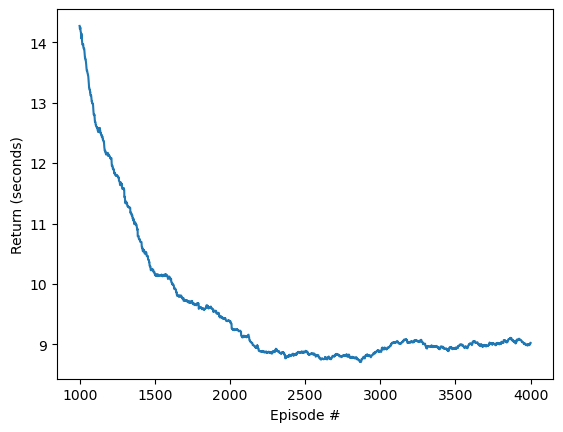

In [15]:
plot_returns(returns, window = 1000)

### Save the model

In [16]:
np.save("saved_models/orla_global/w.npy", orla_glob.w)
torch.save(orla_glob.net.state_dict(), "saved_models/orla_global/model.pt")

### Analysis of the global strategy
Let's see what global strategy $\mathtt{M}_\text{glob}$ takers have learned (note that this is model has been trained for demonstration purposes and its policy may differ from that shown in the paper):

In [17]:
ranking, probs = orla_glob.decode_ranking(True)
glob, arg_val = tkwy.get_global_values(ranking)
ranking = argm.values_to_ranking(arg_val)
tkwy.show_ranking_by_taker(ranking)
glob


    T1:  [['TackleBall1'], ['MinDist1,2', 'MinDist1,3', 'MinDist1,4'], ['MinAngle1,2', 'MinAngle1,3', 'MinAngle1,4'], ['FarKeeper1,2', 'FarKeeper1,3', 'FarKeeper1,4'], ['OpenKeeper1,2', 'OpenKeeper1,3', 'OpenKeeper1,4']]
    T2:  [['TackleBall2'], ['MinDist2,2', 'MinDist2,3', 'MinDist2,4'], ['MinAngle2,2', 'MinAngle2,3', 'MinAngle2,4'], ['FarKeeper2,2', 'FarKeeper2,3', 'FarKeeper2,4'], ['OpenKeeper2,2', 'OpenKeeper2,3', 'OpenKeeper2,4']]
    T3:  [['TackleBall3'], ['MinDist3,2', 'MinDist3,3', 'MinDist3,4'], ['MinAngle3,2', 'MinAngle3,3', 'MinAngle3,4'], ['FarKeeper3,2', 'FarKeeper3,3', 'FarKeeper3,4'], ['OpenKeeper3,2', 'OpenKeeper3,3', 'OpenKeeper3,4']]


{'TackleBall': 38,
 'MinDist': 27,
 'MinAngle': 20,
 'FarKeeper': 14,
 'OpenKeeper': 12}

#### Save the decoded global ranking

In [18]:
argm.save_values(ranking_path, args, arg_val)